### Basic data analysis or exploratory data analysis (EDA)

In [66]:
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
import warnings
warnings.filterwarnings("ignore")

In [128]:
# Read Training dataset as well as drop the index column
training_data = pd.read_csv('./cs-training.csv').drop('Unnamed: 0', axis = 1)


# For each column heading we replace "-" and convert the heading in lowercase 
cleancolumn = []
for i in range(len(training_data.columns)):
    cleancolumn.append(training_data.columns[i].replace('-', '').lower())
training_data.columns = cleancolumn

In [129]:
# print the 5 records of the traiing dataset
training_data.head()

,seriousdlqin2yrs,revolvingutilizationofunsecuredlines,age,numberoftime3059dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime6089dayspastduenotworse,numberofdependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### Handle the outliers

In [130]:
training_data = training_data.fillna(training_data.median())

In [131]:
training_data.isna().sum()

seriousdlqin2yrs                        0
revolvingutilizationofunsecuredlines    0
age                                     0
numberoftime3059dayspastduenotworse     0
debtratio                               0
monthlyincome                           0
numberofopencreditlinesandloans         0
numberoftimes90dayslate                 0
numberrealestateloansorlines            0
numberoftime6089dayspastduenotworse     0
numberofdependents                      0
dtype: int64

Applying log to outliers in parameters that outliers are dominant:
-monthlyincome
-numberoftime3059dayspastduenotworse
-numberoftime6089dayspastduenotworse
-numberoftimes90dayslate
-numberofopencreditlinesandloans
-numberofdependents

In [132]:
training_data.monthlyincome = np.log(training_data.monthlyincome+1)

In [133]:
training_data.numberoftime3059dayspastduenotworse = np.log(training_data.numberoftime3059dayspastduenotworse+1)

In [136]:
training_data.numberoftime6089dayspastduenotworse = np.log(training_data.numberoftime6089dayspastduenotworse+1)

In [137]:
training_data.numberoftimes90dayslate = np.log(training_data.numberoftimes90dayslate+1)

In [138]:
training_data.numberofopencreditlinesandloans = np.log(training_data.numberofopencreditlinesandloans+1)

In [139]:
training_data.numberofdependents = np.log(training_data.numberofdependents+1)

In [141]:
training_data.isna().sum()

seriousdlqin2yrs                        0
revolvingutilizationofunsecuredlines    0
age                                     0
numberoftime3059dayspastduenotworse     0
debtratio                               0
monthlyincome                           0
numberofopencreditlinesandloans         0
numberoftimes90dayslate                 0
numberrealestateloansorlines            0
numberoftime6089dayspastduenotworse     0
numberofdependents                      0
dtype: int64

## Train and build baseline model

In [142]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve
import lightgbm as lgb

In [143]:
X = training_data.drop('seriousdlqin2yrs', axis=1)
y = training_data.seriousdlqin2yrs

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#### KNN 

In [145]:
knMod = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2,
                             metric='minkowski', metric_params=None)

In [146]:
knMod.fit(X_train, y_train)

KNeighborsClassifier()

In [147]:
knMod.score(X_test, y_test)

0.9345866666666667

In [148]:
test_labels=knMod.predict_proba(np.array(X_test.values))[:,1]

In [149]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.6738799680826527

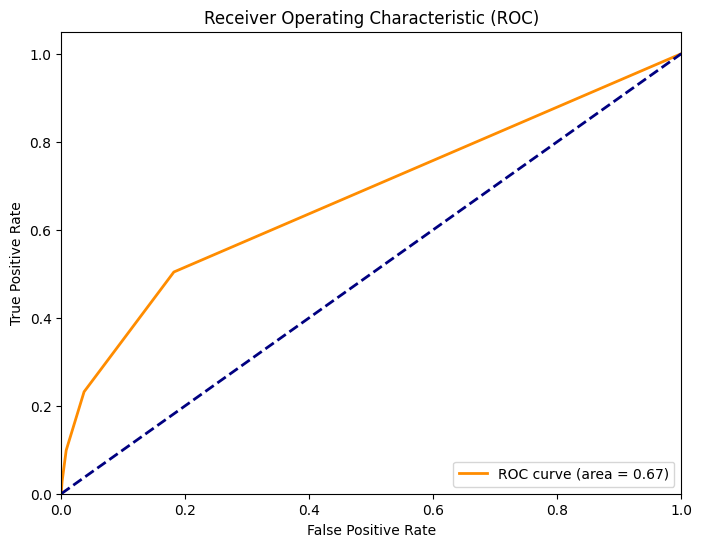

In [150]:
fpr, tpr, thresholds = roc_curve(y_test, test_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#The dashed line on an ROC curve represents a baseline that indicates 
#the performance of a classifier that makes random predictions.

- The curve is above the diagonal line, which suggests that the classifier performs better than random chance. This is a good sign and indicates some ability to distinguish between the two classes.
- The curve approaches the top left corner but not very closely, which means that the classifier has a moderate true positive rate for lower false positive rates, but it doesn't achieve high true positive rates without also increasing the false positive rate significantly.

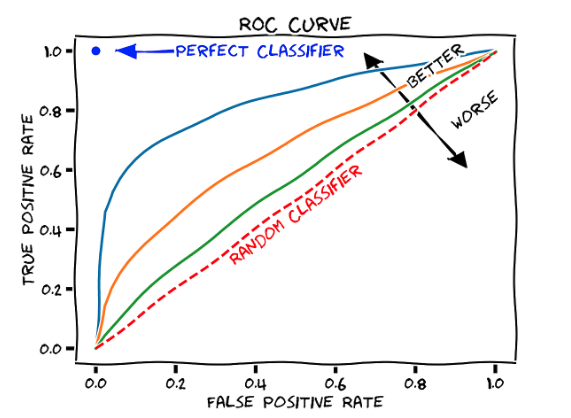

#### Logistic Regression

In [151]:
glmMod = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
                            intercept_scaling=1, class_weight=None, 
                            random_state=None, solver='liblinear', max_iter=100,
                            multi_class='ovr', verbose=2)

In [152]:
glmMod.fit(X_train, y_train)

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 4
iter   5  #CD cycles 1
iter   6  #CD cycles 1
iter   7  #CD cycles 4
iter   8  #CD cycles 4
iter   9  #CD cycles 1
iter  10  #CD cycles 12
iter  11  #CD cycles 4
iter  12  #CD cycles 8
iter  13  #CD cycles 1
iter  14  #CD cycles 32
iter  15  #CD cycles 1
iter  16  #CD cycles 27
iter  17  #CD cycles 31
iter  18  #CD cycles 24
iter  19  #CD cycles 3
iter  20  #CD cycles 2
iter  21  #CD cycles 18
iter  22  #CD cycles 2
iter  23  #CD cycles 5
iter  24  #CD cycles 12
optimization finished, #iter = 24
Objective value = 22922.118357
#nonzeros/#features = 11/11


LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear',
                   verbose=2)

In [153]:
glmMod.score(X_test, y_test)

0.93864

In [154]:
test_labels=glmMod.predict_proba(np.array(X_test.values))[:,1]

In [155]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8202791661166061

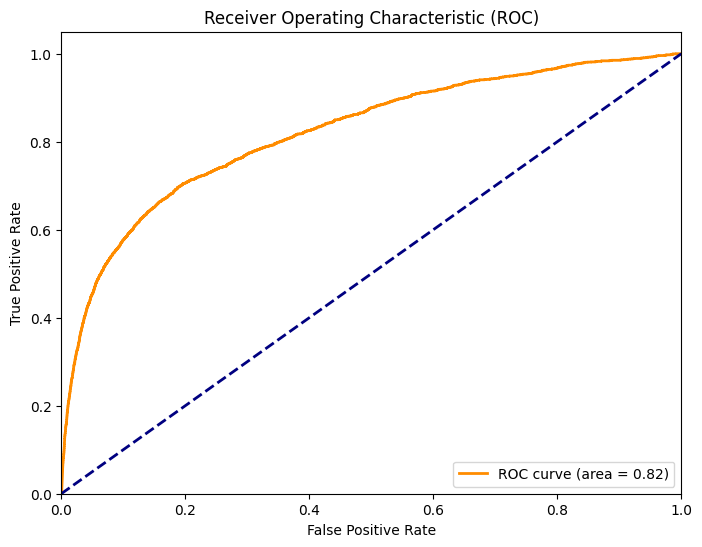

In [156]:
fpr, tpr, thresholds = roc_curve(y_test, test_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#The dashed line on an ROC curve represents a baseline that indicates 
#the performance of a classifier that makes random predictions.

#### Adaboost Classifier

In [157]:
# Deleted base_estimator=None due to error 
adaMod = AdaBoostClassifier(n_estimators=200, learning_rate=1.0)

In [158]:
adaMod.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=200)

In [159]:
adaMod.score(X_test, y_test)

0.93896

In [160]:
test_labels=adaMod.predict_proba(np.array(X_test.values))[:,1]

In [161]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8637238126373717

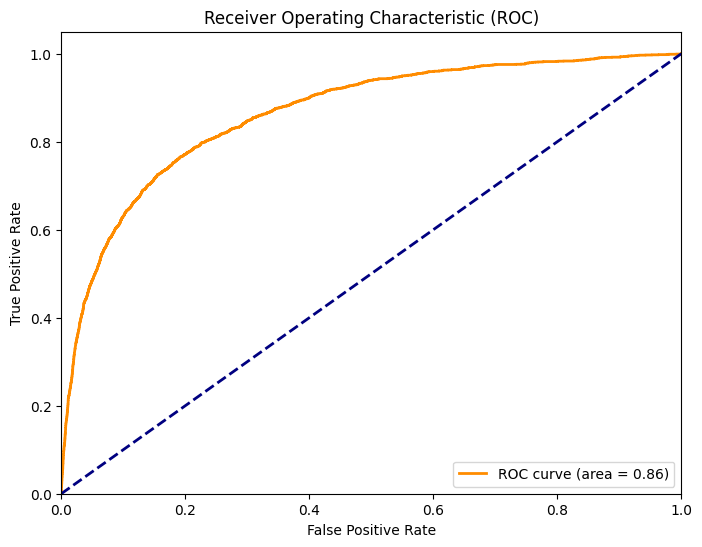

In [162]:
fpr, tpr, thresholds = roc_curve(y_test, test_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#The dashed line on an ROC curve represents a baseline that indicates 
#the performance of a classifier that makes random predictions.

#### Gradientboosting Classifier

In [163]:
gbMod = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0)

In [164]:
gbMod.fit(X_train, y_train)

GradientBoostingClassifier(loss='exponential', n_estimators=200)

In [165]:
gbMod.score(X_test, y_test)

0.93952

In [166]:
test_labels=gbMod.predict_proba(np.array(X_test.values))[:,1]

In [167]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8705727994982952

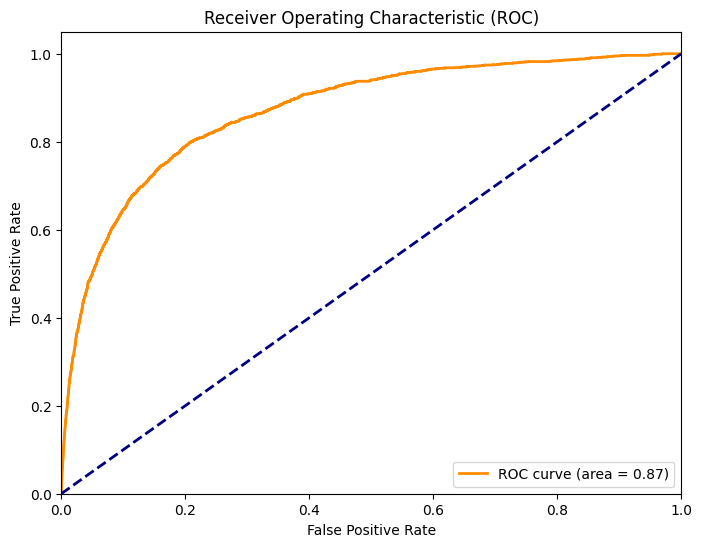

In [168]:
fpr, tpr, thresholds = roc_curve(y_test, test_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#The dashed line on an ROC curve represents a baseline that indicates 
#the performance of a classifier that makes random predictions.

#### Light Gradient Boostin Machine(Newly added)

In [169]:
lgbmMod = lgb.LGBMClassifier(random_state=42, 
                                     num_leaves=31,
                                     max_depth=-1, 
                                     learning_rate=0.1, 
                                     n_estimators=100,
                                     min_child_samples=20)

In [170]:
lgbmMod.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7613, number of negative: 104887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 112500, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067671 -> initscore=-2.623026
[LightGBM] [Info] Start training from score -2.623026


LGBMClassifier(random_state=42)

In [171]:
lgbmMod.score(X_test, y_test)

0.9390666666666667

In [172]:
test_labels=lgbmMod.predict_proba(np.array(X_test.values))[:,1]

In [173]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8692669932017071

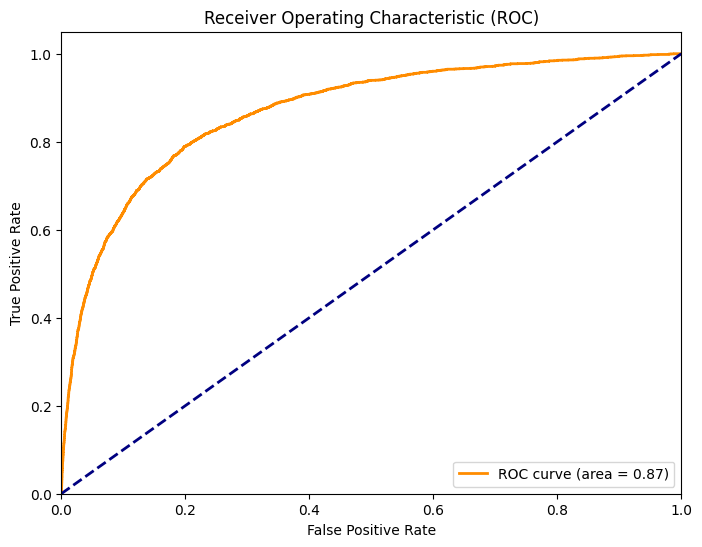

In [174]:
fpr, tpr, thresholds = roc_curve(y_test, test_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#The dashed line on an ROC curve represents a baseline that indicates 
#the performance of a classifier that makes random predictions.

#### RandomForest Classifier

In [175]:
rfMod = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, 
                               random_state=None, verbose=0)

In [176]:
rfMod.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=1)

In [177]:
rfMod.score(X_test, y_test)

0.9347733333333333

In [178]:
test_labels=rfMod.predict_proba(np.array(X_test.values))[:,1]

In [179]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.7899510542328323

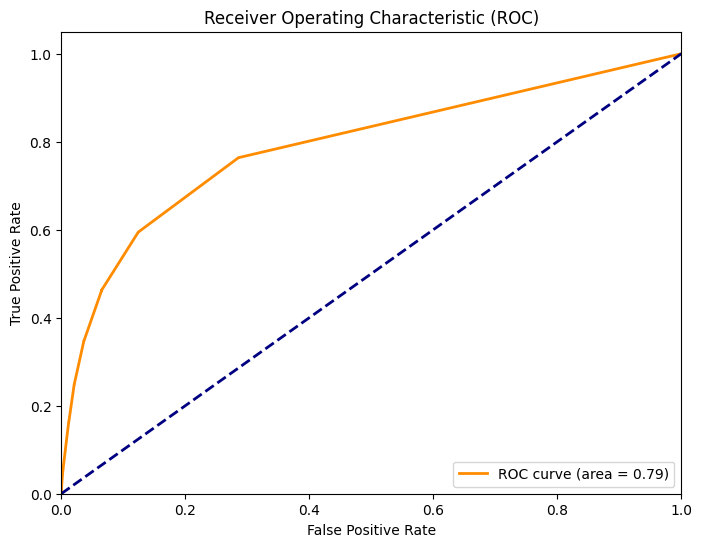

In [180]:
fpr, tpr, thresholds = roc_curve(y_test, test_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#The dashed line on an ROC curve represents a baseline that indicates 
#the performance of a classifier that makes random predictions.

### Cross Validation

In [181]:
from sklearn.model_selection import cross_val_score
def cvDictGen(functions, scr, X_train=X, y_train=y, cv=5, verbose=1):
    cvDict = {}
    for func in functions:
        cvScore = cross_val_score(func, X_train, y_train, cv=cv, verbose=verbose, scoring=scr)
        cvDict[str(func).split('(')[0]] = [cvScore.mean(), cvScore.std()]
    
    return cvDict

def cvDictNormalize(cvDict):
    cvDictNormalized = {}
    for key in cvDict.keys():
        for i in cvDict[key]:
            cvDictNormalized[key] = ['{:0.2f}'.format((cvDict[key][0]/cvDict[cvDict.keys()[0]][0])),
                                     '{:0.2f}'.format((cvDict[key][1]/cvDict[cvDict.keys()[0]][1]))]
    return cvDictNormalized

In [182]:
cvD = cvDictGen(functions=[knMod, glmMod, adaMod, gbMod, lgbmMod, rfMod], scr='roc_auc')
cvD

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 2
iter   6  #CD cycles 1
iter   7  #CD cycles 6
iter   8  #CD cycles 2
iter   9  #CD cycles 2
iter  10  #CD cycles 6
iter  11  #CD cycles 2
iter  12  #CD cycles 1
iter  13  #CD cycles 3
iter  14  #CD cycles 19
iter  15  #CD cycles 1
iter  16  #CD cycles 35
iter  17  #CD cycles 3
iter  18  #CD cycles 4
iter  19  #CD cycles 8
iter  20  #CD cycles 6
iter  21  #CD cycles 1
iter  22  #CD cycles 17
iter  23  #CD cycles 41
iter  24  #CD cycles 11
iter  25  #CD cycles 24
iter  26  #CD cycles 9
iter  27  #CD cycles 6
iter  28  #CD cycles 2
iter  29  #CD cycles 4
iter  30  #CD cycles 8
iter  31  #CD cycles 4
iter  32  #CD cycles 2
iter  33  #CD cycles 1
iter  34  #CD cycles 40
iter  35  #CD cycles 27
iter  36  #CD cycles 1
iter  37  #CD cycles 29
iter  38  #CD cycles 2
iter  39  #CD cycles 7
iter  40  #CD cycles 53
optimization finished, #iter = 40
Objective value = 24153.2

{'KNeighborsClassifier': [0.6753229889406653, 0.0040341112786833775],
 'LogisticRegression': [0.815082867769916, 0.005674448825641811],
 'AdaBoostClassifier': [0.8597286287041795, 0.00248720078101711],
 'GradientBoostingClassifier': [0.8658025349487982, 0.003451202698177442],
 'LGBMClassifier': [0.8645873614338461, 0.002962316481473549],
 'RandomForestClassifier': [0.7813932990860757, 0.0029426185635374313]}

<Axes: >

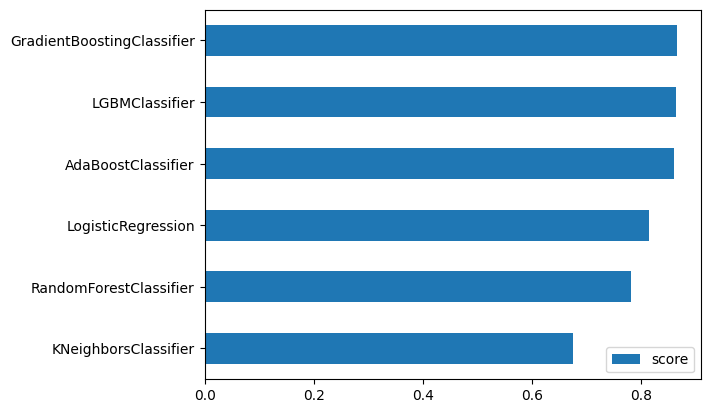

In [183]:
# Added Plot 
key = list(cvD.keys())
values = list([value[0] for value in cvD.values()])

df_temp = pd.DataFrame(values,key)
df_temp.columns = ['score']
df_temp_sorted = df_temp.sort_values(by='score', ascending=True)
df_temp_sorted.plot.barh()

### Hyper parameter optimization using Randomized search

In [184]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

#### AdaBoost

In [185]:
# added learning_rate 
adaHyperParams = {'n_estimators': [10,50,100,420],
                  'learning_rate' : [1, 0.1, 0.01]}

In [186]:
gridSearchAda = RandomizedSearchCV(estimator=adaMod, param_distributions=adaHyperParams, n_iter=5,
                                   scoring='roc_auc', cv=None, verbose=2)

gridSearchAda.fit(X_train, y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   4.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   4.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   4.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   4.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   4.1s
[CV] END ...................learning_rate=1, n_estimators=50; total time=   2.1s
[CV] END ...................learning_rate=1, n_estimators=50; total time=   2.1s
[CV] END ...................learning_rate=1, n_estimators=50; total time=   2.1s
[CV] END ...................learning_rate=1, n_estimators=50; total time=   2.1s
[CV] END ...................learning_rate=1, n_estimators=50; total time=   2.1s
[CV] END ..................learning_rate=1, n_estimators=420; total time=  17.4s
[CV] END ..................learning_rate=1, n_est

RandomizedSearchCV(estimator=AdaBoostClassifier(n_estimators=200), n_iter=5,
                   param_distributions={'learning_rate': [1, 0.1, 0.01],
                                        'n_estimators': [10, 50, 100, 420]},
                   scoring='roc_auc', verbose=2)

In [187]:
gridSearchAda.best_params_, gridSearchAda.best_score_

({'n_estimators': 100, 'learning_rate': 1}, 0.8575466189181489)

#### GradientBoosting

In [188]:
gbHyperParams = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(10, 500),
                 'max_depth': randint(1,10)}

In [189]:
# gridSearchGB = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=10,
#                                    scoring='roc_auc', cv=None, verbose=2)

# gridSearchGB.fit(X_train, y_train)

In [190]:
gridSearchGB = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=10,
                                   scoring='roc_auc', cv=None, verbose=2)

gridSearchGB.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ....loss=exponential, max_depth=4, n_estimators=310; total time=  38.4s
[CV] END ....loss=exponential, max_depth=4, n_estimators=310; total time=  38.7s
[CV] END ....loss=exponential, max_depth=4, n_estimators=310; total time=  38.9s
[CV] END ....loss=exponential, max_depth=4, n_estimators=310; total time=  38.7s
[CV] END ....loss=exponential, max_depth=4, n_estimators=310; total time=  39.0s
[CV] END ....loss=exponential, max_depth=6, n_estimators=459; total time= 1.4min
[CV] END ....loss=exponential, max_depth=6, n_estimators=459; total time= 1.4min
[CV] END ....loss=exponential, max_depth=6, n_estimators=459; total time= 1.4min
[CV] END ....loss=exponential, max_depth=6, n_estimators=459; total time= 1.4min
[CV] END ....loss=exponential, max_depth=6, n_estimators=459; total time= 1.4min
[CV] END ....loss=exponential, max_depth=3, n_estimators=376; total time=  34.8s
[CV] END ....loss=exponential, max_depth=3, n_es

RandomizedSearchCV(estimator=GradientBoostingClassifier(loss='exponential',
                                                        n_estimators=200),
                   param_distributions={'loss': ['deviance', 'exponential'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x296e40990>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x292d26f90>},
                   scoring='roc_auc', verbose=2)

In [191]:
gridSearchGB = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=10,
                                   scoring='roc_auc', cv=None, verbose=2).fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .......loss=deviance, max_depth=4, n_estimators=459; total time=   0.0s
[CV] END .......loss=deviance, max_depth=4, n_estimators=459; total time=   0.0s
[CV] END .......loss=deviance, max_depth=4, n_estimators=459; total time=   0.0s
[CV] END .......loss=deviance, max_depth=4, n_estimators=459; total time=   0.0s
[CV] END .......loss=deviance, max_depth=4, n_estimators=459; total time=   0.0s
[CV] END .......loss=deviance, max_depth=5, n_estimators=301; total time=   0.0s
[CV] END .......loss=deviance, max_depth=5, n_estimators=301; total time=   0.0s
[CV] END .......loss=deviance, max_depth=5, n_estimators=301; total time=   0.0s
[CV] END .......loss=deviance, max_depth=5, n_estimators=301; total time=   0.0s
[CV] END .......loss=deviance, max_depth=5, n_estimators=301; total time=   0.0s
[CV] END ....loss=exponential, max_depth=9, n_estimators=259; total time= 1.2min
[CV] END ....loss=exponential, max_depth=9, n_es

In [192]:
gridSearchGB.best_params_, gridSearchGB.best_score_

({'loss': 'exponential', 'max_depth': 1, 'n_estimators': 210},
 0.8582638667059198)

### Train models with help of new hyper parameter

In [193]:
bestGbModFitted = gridSearchGB.best_estimator_.fit(X_train, y_train)

In [194]:
bestAdaModFitted = gridSearchAda.best_estimator_.fit(X_train, y_train)

In [195]:
cvDictbestpara = cvDictGen(functions=[bestGbModFitted, bestAdaModFitted], scr='roc_auc')

In [196]:
cvDictbestpara

{'GradientBoostingClassifier': [0.8598152795396652, 0.0033830665667707706],
 'AdaBoostClassifier': [0.860177838332219, 0.003066380353568822]}

In [197]:
test_labels=bestGbModFitted.predict_proba(np.array(X_test.values))[:,1]

In [198]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8633385350541418

In [199]:
test_labels=bestAdaModFitted.predict_proba(np.array(X_test.values))[:,1]

In [200]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8637547286254801

### Feature Transformation

In [201]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)
X_train_1 = np.array(X_train)
X_train_transform = transformer.transform(X_train_1)

In [202]:
bestGbModFitted_transformed = gridSearchGB.best_estimator_.fit(X_train_transform, y_train)

In [203]:
bestAdaModFitted_transformed = gridSearchAda.best_estimator_.fit(X_train_transform, y_train)

In [204]:
cvDictbestpara_transform = cvDictGen(functions=[bestGbModFitted_transformed, bestAdaModFitted_transformed],
                                     scr='roc_auc')

In [205]:
cvDictbestpara_transform

{'GradientBoostingClassifier': [0.8598152795396652, 0.0033830665667707706],
 'AdaBoostClassifier': [0.860177838332219, 0.003066380353568822]}

In [206]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)
X_test_1 = np.array(X_test)
X_test_transform = transformer.transform(X_test_1)

In [207]:
X_test_transform

array([[0.10610585, 3.91202301, 0.        , ..., 0.        , 0.        ,
        0.52658903],
       [0.        , 4.11087386, 0.74127631, ..., 0.        , 0.52658903,
        0.        ],
       [0.0521116 , 4.30406509, 0.        , ..., 0.69314718, 0.        ,
        0.52658903],
       ...,
       [0.27318804, 3.71357207, 1.27114985, ..., 0.69314718, 0.52658903,
        0.        ],
       [0.01443269, 4.18965474, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.30157736, 4.24849524, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [208]:
test_labels=bestGbModFitted_transformed.predict_proba(np.array(X_test_transform))[:,1]

In [209]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8633385350541418

In [210]:
test_labels=bestAdaModFitted_transformed.predict_proba(np.array(X_test_transform))[:,1]

In [211]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8637539845157377

### Voting based ensamble model

In [212]:
# Feature transformed
from sklearn.ensemble import VotingClassifier
votingMod = VotingClassifier(estimators=[('gb', bestGbModFitted_transformed), 
                                         ('ada', bestAdaModFitted_transformed)], voting='soft',weights=[2,1])
votingMod = votingMod.fit(X_train_transform, y_train)

In [213]:
test_labels=votingMod.predict_proba(np.array(X_test_transform))[:,1]

In [214]:
votingMod.score(X_test_transform, y_test)

0.9383733333333333

In [215]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8633859336636087

In [216]:
# Feature X transformed 
from sklearn.ensemble import VotingClassifier
votingMod_old = VotingClassifier(estimators=[('gb', bestGbModFitted), ('ada', bestAdaModFitted)], 
                                 voting='soft',weights=[2,1])
votingMod_old = votingMod.fit(X_train, y_train)

- estimators: A list of tuples where each tuple contains a name and the model instance. Here, two models are used: bestGbModFitted_transformed and bestAdaModFitted_transformed, which are presumably pre-trained models based on Gradient Boosting and AdaBoost algorithms, respectively.
- voting='soft': This specifies that soft voting is used, meaning the predictions will be based on the average probabilities from both models.
- weights=[2,1]: This assigns different weights to the models, giving twice as much importance to the predictions from the first model (bestGbModFitted_transformed) compared to the second one (bestAdaModFitted_transformed). This is useful when one model is known to perform better than the other and thus should have a bigger impact on the final decision.


In [217]:
test_labels=votingMod_old.predict_proba(np.array(X_test.values))[:,1]

In [218]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8633859572861402

#### Feature importance of final model

In [219]:
X = training_data.drop('seriousdlqin2yrs', axis=1)
y = training_data.seriousdlqin2yrs
features_label = training_data.columns[1:]
forest = RandomForestClassifier (n_estimators = 10000, random_state=0, n_jobs = -1)
forest.fit(X,y)
importances = forest.feature_importances_
indices = np. argsort(importances)[::-1]
for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_label[i],importances[indices[i]]))

 1) revolvingutilizationofunsecuredlines 0.193643
 2) age                            0.180565
 3) numberoftime3059dayspastduenotworse 0.146228
 4) debtratio                      0.127383
 5) monthlyincome                  0.091039
 6) numberofopencreditlinesandloans 0.088504
 7) numberoftimes90dayslate        0.049589
 8) numberrealestateloansorlines   0.047446
 9) numberoftime6089dayspastduenotworse 0.041828
10) numberofdependents             0.033777


In [220]:
test_labels=bestGbModFitted_transformed.predict_proba(np.array(X_test_transform))[:,1]

In [221]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8633385350541418

In [222]:
test_labels=bestAdaModFitted_transformed.predict_proba(np.array(X_test_transform))[:,1]

In [223]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8637539845157377

### Voting based ensamble model

In [224]:
# Feature transformed
from sklearn.ensemble import VotingClassifier
votingMod = VotingClassifier(estimators=[('gb', bestGbModFitted_transformed), 
                                         ('ada', bestAdaModFitted_transformed)], voting='soft',weights=[2,1])
votingMod = votingMod.fit(X_train_transform, y_train)

In [225]:
test_labels=votingMod.predict_proba(np.array(X_test_transform))[:,1]

In [226]:
votingMod.score(X_test_transform, y_test)

0.9383733333333333

In [227]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8633859336636087

In [228]:
# Feature X transformed 
from sklearn.ensemble import VotingClassifier
votingMod_old = VotingClassifier(estimators=[('gb', bestGbModFitted), ('ada', bestAdaModFitted)], 
                                 voting='soft',weights=[2,1])
votingMod_old = votingMod.fit(X_train, y_train)

- estimators: A list of tuples where each tuple contains a name and the model instance. Here, two models are used: bestGbModFitted_transformed and bestAdaModFitted_transformed, which are presumably pre-trained models based on Gradient Boosting and AdaBoost algorithms, respectively.
- voting='soft': This specifies that soft voting is used, meaning the predictions will be based on the average probabilities from both models.
- weights=[2,1]: This assigns different weights to the models, giving twice as much importance to the predictions from the first model (bestGbModFitted_transformed) compared to the second one (bestAdaModFitted_transformed). This is useful when one model is known to perform better than the other and thus should have a bigger impact on the final decision.


In [229]:
test_labels=votingMod_old.predict_proba(np.array(X_test.values))[:,1]

In [230]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8633859572861402

#### Feature importance of final model

In [231]:
features_label_1 = training_data.columns[1:]
importances_1 = bestGbModFitted.feature_importances_
indices = np. argsort(importances_1)[::-1]
for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_label_1[i],importances_1[indices[i]]))

 1) revolvingutilizationofunsecuredlines 0.417321
 2) age                            0.247083
 3) numberoftime3059dayspastduenotworse 0.154974
 4) debtratio                      0.138309
 5) monthlyincome                  0.014730
 6) numberofopencreditlinesandloans 0.012025
 7) numberoftimes90dayslate        0.007936
 8) numberrealestateloansorlines   0.004397
 9) numberoftime6089dayspastduenotworse 0.003224
10) numberofdependents             0.000000


In [232]:
features_label_2 = training_data.columns[1:]
importances_2 = bestAdaModFitted.feature_importances_
indices = np. argsort(importances_2)[::-1]
for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_label_2[i],importances_2[indices[i]]))

 1) revolvingutilizationofunsecuredlines 0.340000
 2) age                            0.140000
 3) numberoftime3059dayspastduenotworse 0.100000
 4) debtratio                      0.090000
 5) monthlyincome                  0.080000
 6) numberofopencreditlinesandloans 0.070000
 7) numberoftimes90dayslate        0.070000
 8) numberrealestateloansorlines   0.060000
 9) numberoftime6089dayspastduenotworse 0.040000
10) numberofdependents             0.010000


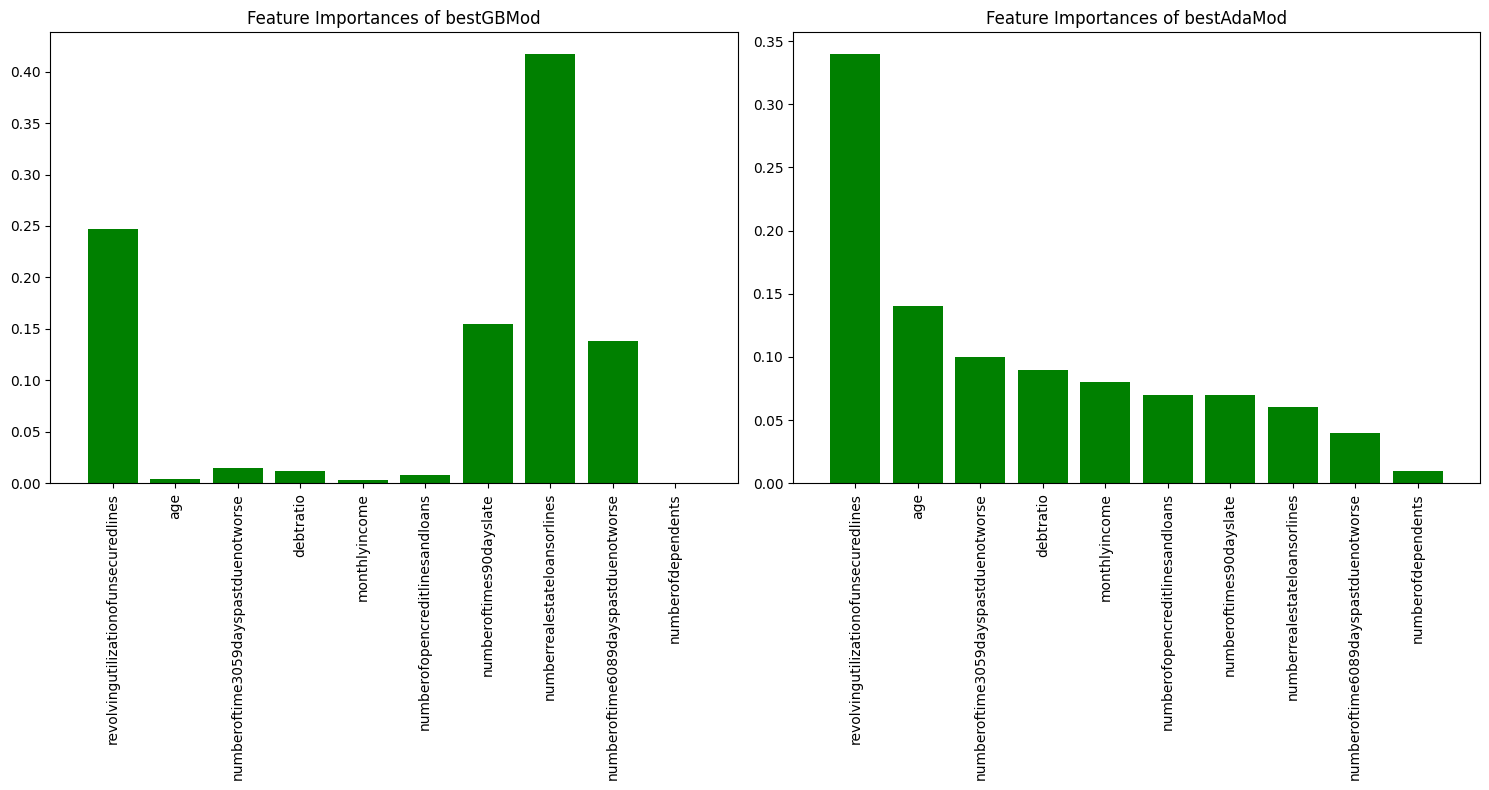

In [233]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns, and adjusting the figure size

# Plot for 'Feature Importances of bestGBMod'
ax[0].bar(range(X.shape[1]), importances_1[indices], color="green", align="center")
ax[0].set_xticks(range(X.shape[1]))
ax[0].set_xticklabels(features_label_1, rotation=90)
ax[0].set_xlim([-1, X.shape[1]])
ax[0].set_title('Feature Importances of bestGBMod')

# Plot for 'Feature Importances of bestAdaMod'
ax[1].bar(range(X.shape[1]), importances_2[indices], color="green", align="center")
ax[1].set_xticks(range(X.shape[1]))
ax[1].set_xticklabels(features_label_2, rotation=90)
ax[1].set_xlim([-1, X.shape[1]])
ax[1].set_title('Feature Importances of bestAdaMod')

plt.tight_layout()  # Adjust the layout to not overlap
plt.show()

### Testing on Real Test Dataset

In [234]:
# Read Training dataset as well as drop the index column
test_data = pd.read_csv('./cs-test.csv').drop('Unnamed: 0', axis = 1)
# For each column heading we replace "-" and convert the heading in lowercase 
cleancolumn = []
for i in range(len(test_data.columns)):
    cleancolumn.append(test_data.columns[i].replace('-', '').lower())
test_data.columns = cleancolumn

In [235]:
test_data.drop(['seriousdlqin2yrs'], axis=1, inplace=True)
test_data.fillna((training_data.median()), inplace=True)

In [236]:
test_labels_votingMod_old = votingMod_old.predict_proba(np.array(test_data.values))[:,1]
print (len(test_labels_votingMod_old))

101503


In [237]:
output = pd.DataFrame({'ID':test_data.index, 'probability':test_labels_votingMod_old})

In [238]:
output.to_csv("./predictions.csv", index=False)

In [239]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

# need to transfrom the test_data because we use model with transformed model 
transformer = FunctionTransformer(np.log1p)
test_data_temp = np.array(test_data)
test_data_transform = transformer.transform(test_data_temp)

In [240]:
test_labels_votingMod = votingMod.predict_proba(np.array(test_data.values))[:,1]
print (len(test_labels_votingMod_old))

101503


In [241]:
output = pd.DataFrame({'ID':test_data.index, 'probability':test_labels_votingMod})

In [242]:
output.to_csv("./predictions_voting_Feature_transformation.csv", index=False)